In [34]:
import pandas as pd
import urllib
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import os
import time
from PIL import Image
from sklearn.model_selection import train_test_split


from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Input, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [4]:
class DownloadingData():
    def __init__(self,file):
        self.data_file = file  
        
    def get_data(self,download_required=False):
        dataset = dict()
        dataset["imageName"] = list()
        dataset["imageWidth"] = list()
        dataset["imageHeight"] = list()
        dataset["xtop"] = list()
        dataset["ytop"] = list()
        dataset["xbottom"] = list()
        dataset["ybottom"] = list()
        
        
        self.data_frame = pd.read_json(self.data_file,lines = True)
        for index, row in self.data_frame.iterrows():
            image_name = "image_{}.jpeg".format(index)
            
            '''Downloading Images'''
            if download_required:
                image_path = os.path.join("data","images",image_name)
                image = urllib.request.urlopen(row["content"])
                image = Image.open(image)
                image = image.convert("RGB")
                image.save(image_path,"JPEG")
            
            dataset["imageName"].append(image_name)
            annotation = row['annotation'][0]
            dataset["imageWidth"].append(annotation["imageWidth"])
            dataset["imageHeight"].append(annotation["imageHeight"])
            dataset["xtop"].append(annotation["points"][0]["x"])
            dataset["ytop"].append(annotation["points"][0]["y"])
            dataset["xbottom"].append(annotation["points"][1]["x"])
            dataset["ybottom"].append(annotation["points"][1]["y"])
        self.data_frame = pd.DataFrame(dataset)
        self.data_frame.to_csv("data/license_plates_detection.csv", index=False)
        print(self.data_frame.head())


In [5]:
file = os.path.join("data","Indian_Number_plates.json")
download_obj = DownloadingData(file)
download_obj.get_data()

      imageName  imageWidth  imageHeight      xtop      ytop   xbottom  \
0  image_0.jpeg         806          466  0.722084  0.587983  0.868486   
1  image_1.jpeg         494          449  0.161943  0.850780  0.582996   
2  image_2.jpeg         500          314  0.082000  0.697452  0.230000   
3  image_3.jpeg         500          469  0.434000  0.667377  0.718000   
4  image_4.jpeg        1001          563  0.208791  0.390764  0.865135   

    ybottom  
0  0.688841  
1  1.000000  
2  0.828025  
3  0.765458  
4  0.984014  


In [43]:
class PreprocessingImage():
    def __init__(self):
        self.width = 224
        self.height = 224
        self.df = download_obj.data_frame
        self.train_df, self.test_df = train_test_split(self.df, test_size=0.10)
        self.train_generator = None
        self.validation_generator = None
        
    def show(self,list):
        for image_id in list:
            image_path = os.path.join("data","images","image_{}.jpeg".format(image_id))
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
            image = cv2.resize(image,dsize = (self.width,self.height))
            
            xtop = int(self.df["xtop"].iloc[image_id] * self.width)
            ytop = int(self.df["ytop"].iloc[image_id] * self.height)
            xbottom = int(self.df["xbottom"].iloc[image_id] * self.width)
            ybottom = int(self.df["ybottom"].iloc[image_id] * self.height)
            
            image = cv2.rectangle(image,(xtop,ytop),(xbottom,ybottom),(0,0,255),1)
            
            plt.imshow(image)
            plt.show()
            
    def data_generation(self):
        datagen = ImageDataGenerator(rescale=1./255, validation_split=0.1)
        self.train_generator = datagen.flow_from_dataframe(
            self.train_df,
            directory="data/images/",
            x_col="imageName",
            y_col=["xtop", "ytop", "xbottom", "ybottom"],
            target_size=(self.width, self.height),
            batch_size=32, 
            class_mode="other",
            subset="training")

        self.validation_generator = datagen.flow_from_dataframe(
            self.train_df,
            directory="data/images/",
            x_col="imageName",
            y_col=["xtop", "ytop", "xbottom", "ybottom"],
            target_size=(self.width, self.height),
            batch_size=32, 
            class_mode="other",
            subset="validation")

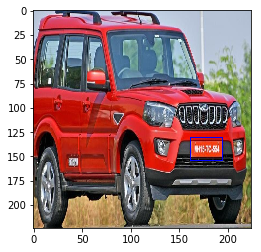

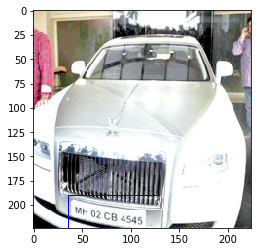

Found 192 validated image filenames.
Found 21 validated image filenames.


In [44]:
preprocess_obj = PreprocessingImage()
preprocess_obj.show([0,1])
preprocess_obj.data_generation()

In [45]:
class DesignModel():
    def __init__(self):
        self.width = 224
        self.height = 224
        self.channel = 3
        self.shape = (self.height,self.width,self.channel)
        self.model = None
        self.history = None
        self.train_generator = preprocess_obj.train_generator
        self.validation_generator = preprocess_obj.validation_generator
        
        self.step_size_train = int(np.ceil(self.train_generator.n / self.train_generator.batch_size))
        self.step_size_valid = int(np.ceil(self.validation_generator.n / self.validation_generator.batch_size))
        self.train_generator.reset()
        self.validation_generator.reset()
        
        
    def get_model(self):
        model = Sequential()
        model.add(VGG16(weights="imagenet",include_top = False, input_shape = self.shape))
        model.add(Flatten())
        model.add(Dense(128, activation="relu"))
        model.add(Dense(64, activation="relu"))
        model.add(Dense(64, activation="relu"))
        model.add(Dense(4, activation="sigmoid"))
        model.layers[-6].trainable = False

        self.model = model
        
    def get_simple_model(self):
        model = Sequential()

        model.add(Conv2D(32, (3, 3), activation='relu', input_shape=self.shape))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        model.add(Conv2D(128, (3, 3), activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        model.add(Flatten())
        model.add(Dense(512, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
        model.add(Dense(4, activation='sigmoid'))
        self.model = model
        
        
    def compile_model(self):
        adam = Adam(lr=0.0005)
        self.model.compile(optimizer=adam, loss="mse",metrics=["accuracy"])
        
    def train_model(self):
        self.history = self.model.fit_generator(self.train_generator,
                        steps_per_epoch=self.step_size_train,
                        validation_data=self.validation_generator,
                        validation_steps=self.step_size_valid,
                        epochs=100)        

In [46]:
model_obj = DesignModel()
model_obj.get_simple_model()
model_obj.compile_model()
model_obj.train_model()

Epoch 1/100
6/6 [==============================] - 16s 3s/step - loss: 0.1721 - acc: 0.2812 - val_loss: 0.0429 - val_acc: 0.6667
Epoch 2/100
6/6 [==============================] - 17s 3s/step - loss: 0.1375 - acc: 0.3854 - val_loss: 0.0716 - val_acc: 0.6667
Epoch 3/100
6/6 [==============================] - 17s 3s/step - loss: 0.1203 - acc: 0.3854 - val_loss: 0.0974 - val_acc: 0.6667
Epoch 4/100
6/6 [==============================] - 16s 3s/step - loss: 0.1055 - acc: 0.3854 - val_loss: 0.1222 - val_acc: 0.6667
Epoch 5/100
6/6 [==============================] - 16s 3s/step - loss: 0.0914 - acc: 0.3958 - val_loss: 0.1445 - val_acc: 0.6667
Epoch 6/100
6/6 [==============================] - 16s 3s/step - loss: 0.0817 - acc: 0.4115 - val_loss: 0.1539 - val_acc: 0.6667
Epoch 7/100
6/6 [==============================] - 16s 3s/step - loss: 0.0790 - acc: 0.4479 - val_loss: 0.1603 - val_acc: 0.6667
Epoch 8/100
6/6 [==============================] - 16s 3s/step - loss: 0.0699 - acc: 0.4844 - val

Epoch 64/100
6/6 [==============================] - 18s 3s/step - loss: 0.0253 - acc: 0.6771 - val_loss: 0.1083 - val_acc: 0.2857
Epoch 65/100
6/6 [==============================] - 18s 3s/step - loss: 0.0282 - acc: 0.7448 - val_loss: 0.0845 - val_acc: 0.3333
Epoch 66/100
6/6 [==============================] - 17s 3s/step - loss: 0.0249 - acc: 0.7552 - val_loss: 0.0858 - val_acc: 0.3333
Epoch 67/100
6/6 [==============================] - 17s 3s/step - loss: 0.0239 - acc: 0.6979 - val_loss: 0.0916 - val_acc: 0.3333
Epoch 68/100
6/6 [==============================] - 18s 3s/step - loss: 0.0241 - acc: 0.6927 - val_loss: 0.1037 - val_acc: 0.3333
Epoch 69/100
6/6 [==============================] - 18s 3s/step - loss: 0.0273 - acc: 0.7031 - val_loss: 0.1115 - val_acc: 0.3333
Epoch 70/100
6/6 [==============================] - 19s 3s/step - loss: 0.0277 - acc: 0.6302 - val_loss: 0.1086 - val_acc: 0.3333
Epoch 71/100
6/6 [==============================] - 21s 3s/step - loss: 0.0258 - acc: 0.67

In [47]:
class Prediction():
    def __init__(self):
        self.width = 224
        self.height = 224
        self.channel = 3
        self.model = model_obj.model
        self.data = preprocess_obj.test_df["imageName"]
        
    def predict(self,image):
        img = cv2.resize(cv2.imread("data/images/" + image) / 255.0, dsize=(self.width, self.height))
        y_hat = self.model.predict(img.reshape(1, self.width, self.height, self.channel)).reshape(-1) * self.width
        xt, yt = y_hat[0], y_hat[1]
        xb, yb = y_hat[2], y_hat[3]

        img = cv2.cvtColor(img.astype(np.float32), cv2.COLOR_BGR2RGB)
        image = cv2.rectangle(img, (xt, yt), (xb, yb), (0, 0, 255), 1)
        plt.imshow(image)
        plt.show()
        
    def predict_test_data(self):
        for image in self.data:
            self.predict(image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


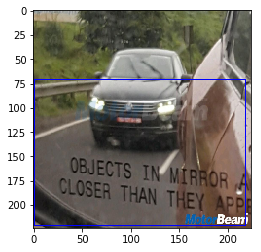

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


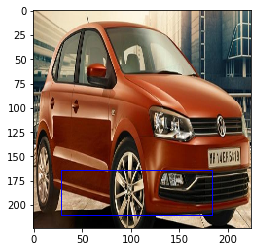

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


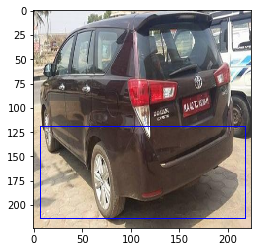

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


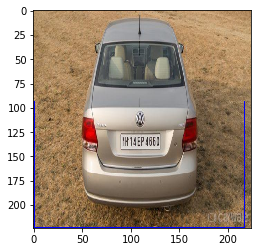

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


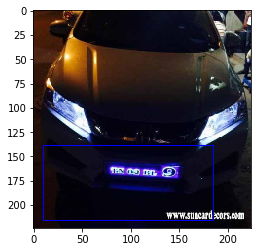

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


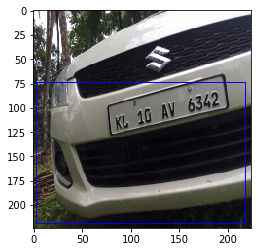

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


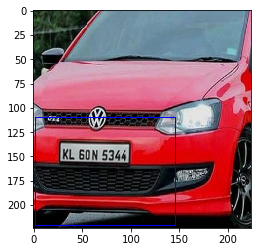

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


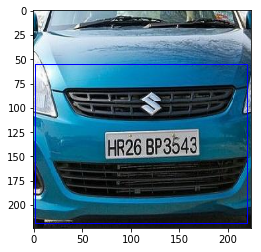

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


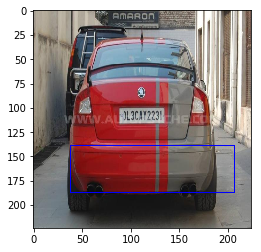

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


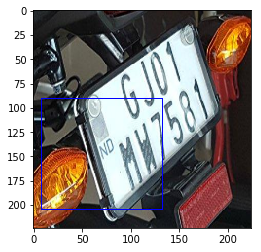

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


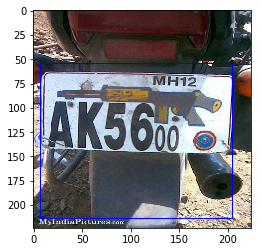

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


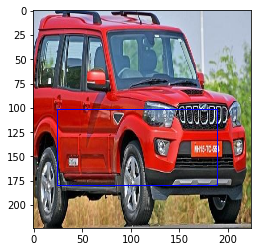

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


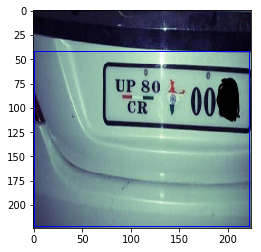

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


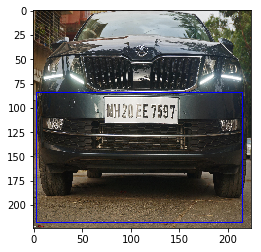

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


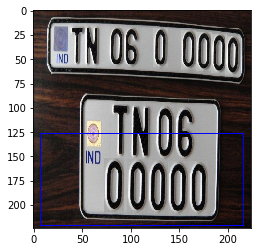

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


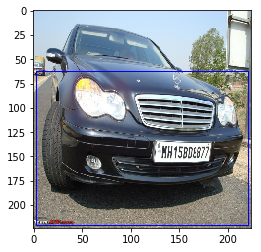

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


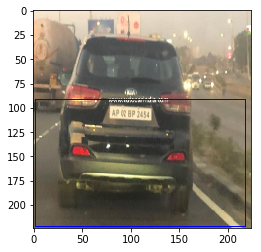

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


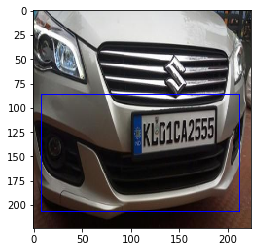

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


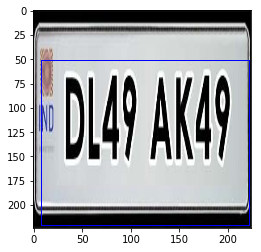

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


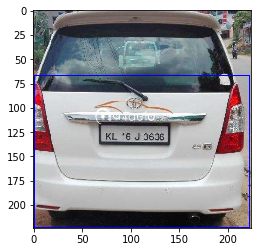

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


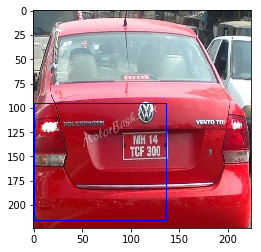

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


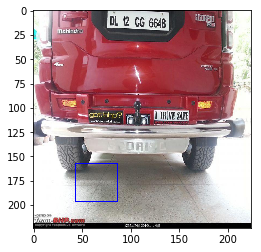

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


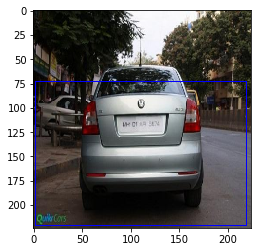

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


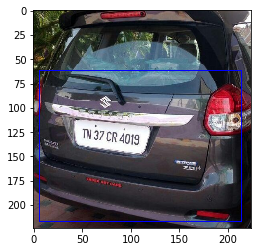

In [48]:
pred_obj = Prediction()
pred_obj.predict_test_data()